<p align="center"><h1><font color = "green">Mini Pet-project #2 by Nikolay Luzhynski</font></h1></p>
<h2>Sentiment Analysis of IMDB Movie Reviews</h2>
</br>
<hr/>
<h4><b><i>Цель проекта:</i></b></h4> <i>Бинарная классификация рецензий по фильму: позитивная/негативная</i>
<h4><b><i>Входные данные:</i></b></h4> <i>Данные были взяты из открытого соревнования на <a href = "https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews" target="_blank">Kaggle</a></i>
    <h4><b><i>Используемые модели:</i></b></h4><i>LogisticRegression, SGDClassifier, LinearSVC
</i>
<h4><b><i>Метрики качества модели:</i></b></h4><i>accuracy score</i>
<h4><b><i>Итоги:</i></b></h4>
    <i>Получилось построить модель,которая на тестовой выборке показывает 90% точность бинарной классификации рецензий.</i></br>
     <i>Также в рабочей бумаге были рассмотрены иные методы векторизации данных: TF-IDF и HashingVectorizer.</i>

<h2>Содержание</h2>

[1.Импорт библиотек и данных](#1_1)

[2.Обработка данных](#2_1)

[3.Обучение данных](#3_1)

[4. TF-IDF](#5_1)

[5. HashingVectorizer](#6_1)

<a id='1_1'><h2>1.1 Импорт библиотек</h2></a>

In [56]:
# основные библиотеки
import os
import pandas as pd
import numpy as np

# для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# для обработки данных и удаления стоп-слов
import nltk 
#nltk.download('stopwords')
from nltk.corpus import stopwords

# для работы с регулярными выражениями
import re

# необходимые модели и метрики
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (accuracy_score, auc, roc_curve)
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import HashingVectorizer

# отключаем предупреждения
import warnings
warnings.filterwarnings("ignore")

RAND = 8

<a id='1_2'><h2>1.2 Импорт данных</h2></a>

In [7]:
PATH_TO_DATA = 'dataset/' # искомая папка с данными

In [8]:
ls dataset 

IMDB Dataset.csv


In [9]:
df = pd.read_csv(os.path.join(PATH_TO_DATA,'IMDB Dataset.csv'))

In [10]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<a id='2_1'><h2>2. Обработка данных</h2></a>

In [11]:
df.shape

(50000, 2)

In [12]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [13]:
df['sentiment'].value_counts() # смотрим на распределение целевой переменной

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [15]:
# приведем целевую переменную к бинарной класификации
# 1 - positive review
# 0 - negative review
df['sentiment'] = df['sentiment'].map({'positive':1,'negative':0})

In [16]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [17]:
df.loc[0,'review'] # посмотрим на 1-ый отзыв

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

<h3>Почистим отзывы от мусора, HTML-тегов, приведем к единой раскладке </h3>

In [18]:
df['review'] = df['review'].apply(lambda x: re.sub(r'\<[^>]*\>', '', x))
df['review'] = df['review'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
df['review'] = df['review'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))
df['review'] = df['review'].apply(lambda x: x.lower())
df['review'] = df['review'].apply(lambda x: x.strip())

In [19]:
# создаем токенизатор и загружаем стоп-слова
WPT = nltk.WordPunctTokenizer()
stop_word_list = nltk.corpus.stopwords.words('english')

In [20]:
def token(values):
    words = nltk.tokenize.word_tokenize(values)
    filtered_words = [word for word in words if word not in set(stopwords.words("english"))]
    not_stopword_doc = " ".join(filtered_words)
    return not_stopword_doc

In [21]:
%%time
#df['review'] = df['review'].apply(lambda x: token(x))

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


In [22]:
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there s a family where a little boy ...,0
4,petter mattei s love in the time of money is a...,1


In [23]:
df = pd.read_csv(PATH_TO_DATA + 'Processed_df.csv')

In [24]:
df.shape

(50000, 2)

In [25]:
df.loc[0,'review'] # посмотрим на обработанный отзыв

'one reviewers mentioned watching oz episode hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awayi would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lac

<a id='3_1'><h2>3. Обучение моделей</h2></a>

In [26]:
# разбиваем выборку на тренировочную и тестовую в пропорции 80/20
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], 
                                                    test_size = 0.2, random_state=RAND)

<h4>Предобработаем даннные при помощи "Мешка слов"</h4>

In [27]:
%%time
cv = CountVectorizer(ngram_range=(1,2))
X_train_sparse = cv.fit_transform(X_train) # обучим и сразу трансформируем тестовую выборку
X_test_sparse = cv.transform(X_test) # посколько модель была обучена, только трансформируем, чтобы сохранить размерность

CPU times: user 13.3 s, sys: 513 ms, total: 13.8 s
Wall time: 14 s


In [28]:
X_train_sparse.shape, X_test_sparse.shape

((40000, 2811294), (10000, 2811294))

<h4>Попробуем обучить логистическую регрессию и посмотрим на accuracy score на отложенной выборке</h4>

In [29]:
logit = LogisticRegression(random_state=RAND, n_jobs=-1)

In [30]:
%%time
logit.fit(X_train_sparse, y_train)

CPU times: user 493 ms, sys: 236 ms, total: 729 ms
Wall time: 26.7 s


LogisticRegression(n_jobs=-1, random_state=8)

In [31]:
accuracy_score(y_test, logit.predict(X_test_sparse))

0.9008

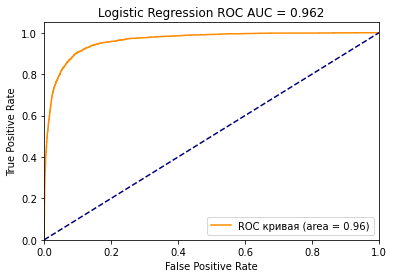

In [32]:
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, logit.predict_proba(X_test_sparse)[:,1])
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

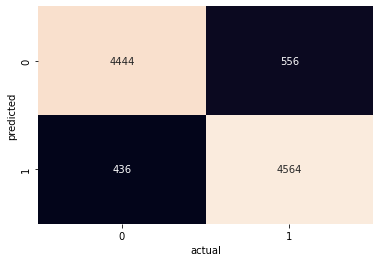

In [33]:
# Посмотрим на матрицу ошибок
matrix = pd.crosstab(y_test, logit.predict(X_test_sparse), rownames=['predicted'], colnames=['actual'])
sns.heatmap(matrix, annot = True, fmt='.5g', cbar=False);

In [34]:
# Создадим ДФ, куда будем заносить результаты по разным моделям
metrics = pd.DataFrame(
            index = ['accuracy'])
metrics['Logit'] = [accuracy_score(y_test, logit.predict(X_test_sparse))]

In [35]:
metrics

,Logit
accuracy,0.9008


<h4>Видим, что результат получился хорошим</h4>

<h4>Проанализируем важность признаков</h4>

In [36]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(
        np.arange(1, 1 + 2 * n_top_features),
        feature_names[interesting_coefficients],
        rotation=60,
        ha="right",
    );

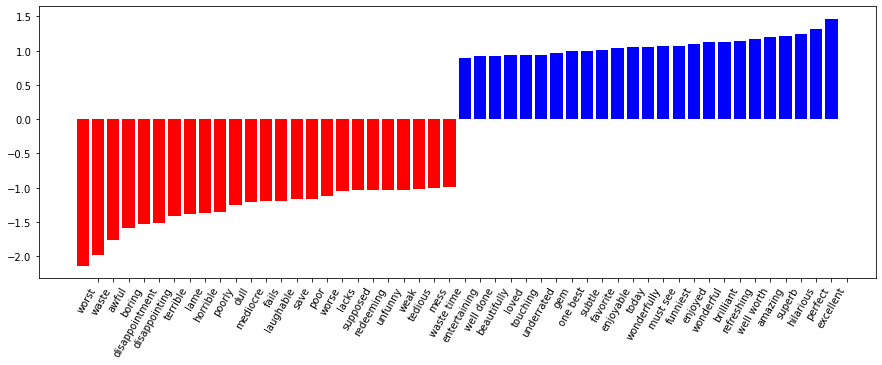

In [37]:
visualize_coefficients(logit, cv.get_feature_names())

### Обучим также Линейный SVM и Стохастический градиентный бустинг

In [38]:
# Создадим функцию для обучения моделей и вывода результа
def prediction(model,name_model, X_train,X_test, y_train,y_test):
    model.fit(X_train, y_train)
    metrics[name_model] = accuracy_score(y_test, model.predict(X_test))
    print(f"Accuracy score - {accuracy_score(y_test, model.predict(X_test))}")

In [39]:
%%time 
prediction(SGDClassifier(max_iter=500, random_state=RAND, n_jobs=-1),
          'SGD',
          X_train_sparse,
          X_test_sparse,
          y_train,
          y_test)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 16.9 µs
Accuracy score - 0.8941


In [40]:
%%time 
prediction(LinearSVC(random_state=RAND),
          'LinearSVC',
          X_train_sparse,
          X_test_sparse,
          y_train,
          y_test)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 11.2 µs
Accuracy score - 0.9026


In [43]:
metrics

,Logit,SGD,LinearSVC
accuracy,0.9008,0.8941,0.9026


### Мы видим, что лучший результат показал линейный SVM

<a id='5_1'><h2>5. TF-IDF</h2></a>

#### Альтернативой является вычисление частот слов, и, безусловно, самый популярный метод называетсяTF-IDF, Это аббревиатура, что означает «Периодичность - обратный документЧастота, составляющая составляющие итоговой оценки, присваивается каждому слову.

Срок Частота: Это суммирует, как часто данное слово появляется в документе.
Частота обратных документов: Это уменьшает количество слов, которые часто встречаются в документах.
Не вдаваясь в математику, TF-IDF являются показателями частоты слов, которые пытаются выделить слова, которые более интересны, например, часто в документе, но не в документах.

TfidfVectorizerпроведет токенизацию документов, изучит словарный запас и весовые коэффициенты обратных документов и позволит вам кодировать новые документы.

In [53]:
text_pipe_logit = make_pipeline(TfidfVectorizer(ngram_range=(1,2)), 
                                LogisticRegression(random_state=RAND, n_jobs=-1))

In [54]:
text_pipe_logit.fit(X_train, y_train)
metrics[name_model] = 
print(text_pipe_logit.score(X_test, y_test))

0.8968


In [15]:
text_pipe_SVM = make_pipeline(TfidfVectorizer(), 
                                LinearSVC(random_state=RAND))

In [16]:
text_pipe_SVM.fit(X_train, y_train)
print(text_pipe_SVM.score(X_test, y_test))

0.8995


In [42]:
text_pipe_SGD = make_pipeline(TfidfVectorizer(), 
                                SGDClassifier(loss='log',random_state=RAND))

In [43]:
text_pipe_SGD.fit(X_train, y_train)
print(text_pipe_SGD.score(X_test, y_test))

0.886


<a id='6_1'><h2>6. HashingVectorizer</h2></a>

### Подсчеты и частоты могут быть очень полезны, но одним из ограничений этих методов является то, что словарный запас может стать очень большим.

Это, в свою очередь, потребует больших векторов для кодирования документов и налагает большие требования к памяти и замедляет алгоритмы.

Умный обходной путь - использовать односторонний хэш слов, чтобы преобразовать их в целые числа. Умная часть заключается в том, что словарь не требуется, и вы можете выбрать произвольный длинный вектор фиксированной длины. Недостатком является то, что хеш является односторонней функцией, поэтому нет способа преобразовать кодировку обратно в слово (что может не иметь значения для многих контролируемых задач обучения).

HashingVectorizer Класс реализует этот подход, который можно использовать для последовательного хеширования слов, а затем для токенизации и кодирования документов по мере необходимости.

In [57]:
text_pipe_logit = make_pipeline(HashingVectorizer(), 
                                LogisticRegression(random_state=RAND, n_jobs=-1))

In [58]:
text_pipe_logit.fit(X_train, y_train)
print(text_pipe_logit.score(X_test, y_test))

0.8881


In [59]:
text_pipe_SVM = make_pipeline(HashingVectorizer(), 
                                LinearSVC(random_state=RAND))

In [60]:
text_pipe_SVM.fit(X_train, y_train)
print(text_pipe_SVM.score(X_test, y_test))

0.8975


In [61]:
text_pipe_SGD = make_pipeline(HashingVectorizer(), 
                                SGDClassifier(loss='log',random_state=RAND))

In [62]:
text_pipe_SGD.fit(X_train, y_train)
print(text_pipe_SGD.score(X_test, y_test))

0.8739
